In [15]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as md
import nglview as ng
plt.style.use('seaborn-poster')

In [2]:
u1 = md.Universe('../Rama-Crystal-1/NPT/simfiles/init.gro')
u2 = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro')

In [3]:
crystal_waters = u1.select_atoms('resname HOH and name OW')

In [4]:
water_coords = crystal_waters.positions

In [5]:
waters2 = u2.select_atoms('resname SOL')

In [6]:
waters2

<AtomGroup with 3477 atoms>

In [7]:
crystal_waters

<AtomGroup with 376 atoms>

In [73]:
that_water1 = u1.select_atoms('resname HOH and resid 518 and name OW')

In [74]:
this_water2 = u2.select_atoms('resname SOL and resid 631 and name OW')

In [75]:
this_water2.positions

array([[ 29.17    , -11.280001,   8.7     ]], dtype=float32)

In [76]:
that_water1.positions

array([[18.09     , -7.0499997, 25.89     ],
       [50.75     , 12.67     , 25.89     ],
       [29.17     , -7.0499997,  8.7      ],
       [-3.48     , 12.67     ,  8.7      ]], dtype=float32)

In [77]:
crystal_water_coordinates = water_coords

In [78]:
water_coords

array([[21.189999  , 12.57      , -2.9699998 ],
       [ 2.73      ,  9.43      , -0.78000003],
       [ 5.84      ,  4.79      , 10.039999  ],
       ...,
       [-7.7200003 , 29.119999  , 36.55      ],
       [-0.96000004, 21.619999  , 19.119999  ],
       [ 4.44      , 51.39      , 25.02      ]], dtype=float32)

In [79]:
crystal_water_coordinates = water_coords - np.array([0.0, 4.23, 0.0]) 

In [451]:
crystal_water_coordinates

array([[21.18999863,  8.33999969, -2.96999979],
       [ 2.73000002,  5.20000031, -0.78000003],
       [ 5.84000015,  0.55999996, 10.03999901],
       ...,
       [-7.72000027, 24.88999893, 36.54999924],
       [-0.96000004, 17.38999893, 19.11999893],
       [ 4.44000006, 47.15999939, 25.02000046]])

In [450]:
crystal_water_coordinates.shape

(376, 3)

In [344]:
u_emin = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro','../Rama-Crystal-1/NPT/energyMinRun/confout.gro')

In [345]:
u_emin.trajectory

<GROReader ../Rama-Crystal-1/NPT/energyMinRun/confout.gro with 1 frames of 9373 atoms>

In [349]:
#d = np.linalg.norm(CA_atoms[i].position - CA_atoms[j].position)
u_emin.trajectory[0]
waters = u_emin.select_atoms('resname SOL and name OW')
import numpy as np

In [350]:
crystal_waters_atomgroup = u2.select_atoms('resname LLLLL')
for i, coord in enumerate(crystal_water_coordinates):
    found = False
    for atom in u2.select_atoms('resname SOL and name OW'):
        if np.linalg.norm(atom.position - coord) < 0.1:
            crystal_waters_atomgroup += atom
            found = True
    if not found:
        print(coord, i)
print(crystal_waters_atomgroup.n_atoms)

[11.77000046 -4.01       -1.49000001] 40
[ 9.68999958 -2.0799999   5.36000013] 52
[46.14999771  2.33000042 35.43999863] 193
[31.42000008 17.17000153 38.40999985] 233
[ 6.11000013 19.38999893 22.52000046] 340
[12.98999977 39.70000031 23.15000153] 347
370


### Some of the crystal waters were not found in the genion_solvate structure. I do not care

In [351]:
crystal_waters.atoms[40]

<Atom 6005: OW of type O of resname HOH, resid 541 and segid SYSTEM>

### crystal_water_atomgroup is the AtomGroup where all crystal molecules are defined in solvate_genion

In [434]:
for xz in crystal_waters_atomgroup:
    print(xz)

<Atom 5885: OW of type O of resname SOL, resid 429 and segid SYSTEM>
<Atom 5888: OW of type O of resname SOL, resid 430 and segid SYSTEM>
<Atom 5891: OW of type O of resname SOL, resid 431 and segid SYSTEM>
<Atom 5894: OW of type O of resname SOL, resid 432 and segid SYSTEM>
<Atom 5897: OW of type O of resname SOL, resid 433 and segid SYSTEM>
<Atom 5900: OW of type O of resname SOL, resid 434 and segid SYSTEM>
<Atom 5903: OW of type O of resname SOL, resid 435 and segid SYSTEM>
<Atom 5906: OW of type O of resname SOL, resid 436 and segid SYSTEM>
<Atom 5909: OW of type O of resname SOL, resid 437 and segid SYSTEM>
<Atom 5912: OW of type O of resname SOL, resid 438 and segid SYSTEM>
<Atom 5915: OW of type O of resname SOL, resid 439 and segid SYSTEM>
<Atom 5918: OW of type O of resname SOL, resid 440 and segid SYSTEM>
<Atom 5921: OW of type O of resname SOL, resid 441 and segid SYSTEM>
<Atom 5924: OW of type O of resname SOL, resid 442 and segid SYSTEM>
<Atom 5927: OW of type O of resnam

In [412]:
crystal_waters_selection = u_emin.select_atoms('resname HUI')
for atom in crystal_waters_atomgroup:
    crystal_waters_selection += u_emin.atoms[atom.index] 
print(crystal_waters_selection.n_atoms) 

fixed_coordinates = np.empty((1000, 3))
for ts in u_emin.trajectory:
    fixed_coordinates = crystal_waters_selection.positions.copy()
print(fixed_coordinates.shape)

370
(370, 3)


In [435]:
fixed_coordinates = crystal_waters_atomgroup.positions.copy()

In [436]:
fixed_coordinates

array([[21.189999  ,  8.34      , -2.9699998 ],
       [ 2.73      ,  5.2       , -0.78000003],
       [ 5.84      ,  0.56      , 10.039999  ],
       ...,
       [-7.7200003 , 24.890001  , 36.55      ],
       [-0.96000004, 17.39      , 19.119999  ],
       [ 4.44      , 47.16      , 25.02      ]], dtype=float32)

In [120]:
u2.atoms[6994].position, u2.atoms[6997].position, u2.atoms[7000].position, u2.atoms[7003].position, u2.atoms[7006].position, u2.atoms[7009].position

(array([ 9.73,  8.9 , 15.72], dtype=float32),
 array([ 4.61, 12.66, 17.27], dtype=float32),
 array([5.39      , 0.64000005, 5.1200004 ], dtype=float32),
 array([15.92    , 16.289999, 16.25    ], dtype=float32),
 array([ 9.150001 ,  0.89     , 14.0199995], dtype=float32),
 array([ 7.0499997, 10.5      ,  3.68     ], dtype=float32))

In [3]:
u_berendsen = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro','../Rama-Crystal-1/NPT/BerendsenRun/traj.xtc')
ng.show_mdanalysis(u_berendsen, gui=True)

/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget(count=1001)

In [358]:
from MDAnalysis.analysis.distances import distance_array
box1 = [ 65.3, 39.45, 39.01,  90., 117.54004,  90.]

In [421]:
fixed_coordinates[0]

array([21.189999 ,  8.34     , -2.9699998], dtype=float32)

In [360]:
cutoff = 2.5

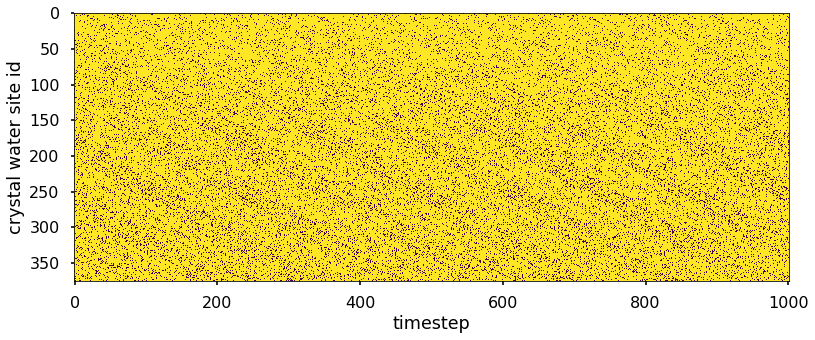

In [453]:
crystal_water_coordinates = crystal_water_coordinates.astype(np.float32)

u_berendsen = md.Universe('../Rama-Crystal-1/NPT/BerendsenRun/Berendsen.gro','../Rama-Crystal-1/NPT/BerendsenRun/traj.xtc')
occupancy = np.zeros((1001, 376))
#result = np.empty((370, 1159))
oxygens = u_berendsen.select_atoms('resname SOL and name OW')
counter = 0
for ts in u_berendsen.trajectory:
    box = ts.dimensions
    d = distance_array(crystal_water_coordinates.reshape((-1, 3)), oxygens.positions, box=box, result=None, backend='OpenMP')
    mindist = np.min(d, axis=1)
    occupancy[counter] = mindist
    counter += 1
plt.imshow(occupancy.reshape((376,-1)) < cutoff)
plt.xlabel('timestep')
plt.ylabel('crystal water site id')
plt.show()

In [454]:
av_percent = np.sum(occupancy < cutoff, axis = 0) / 1001.

In [457]:
percent = np.sum(occupancy < cutoff, axis = 1) / 376.

Text(0, 0.5, 'crystal water sites occupancy')

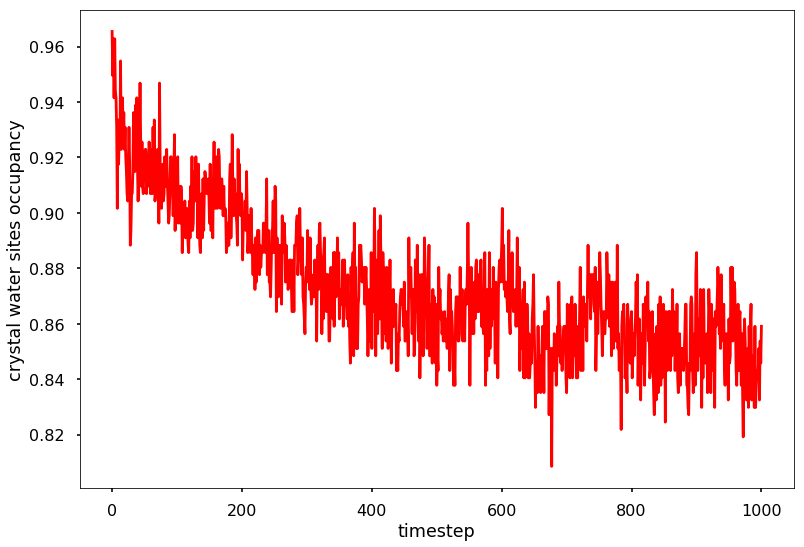

In [458]:
plt.plot(percent, 'r-')
plt.xlabel('timestep')
plt.ylabel('crystal water sites occupancy')

Text(0, 0.5, 'crystal water sites occupancy')

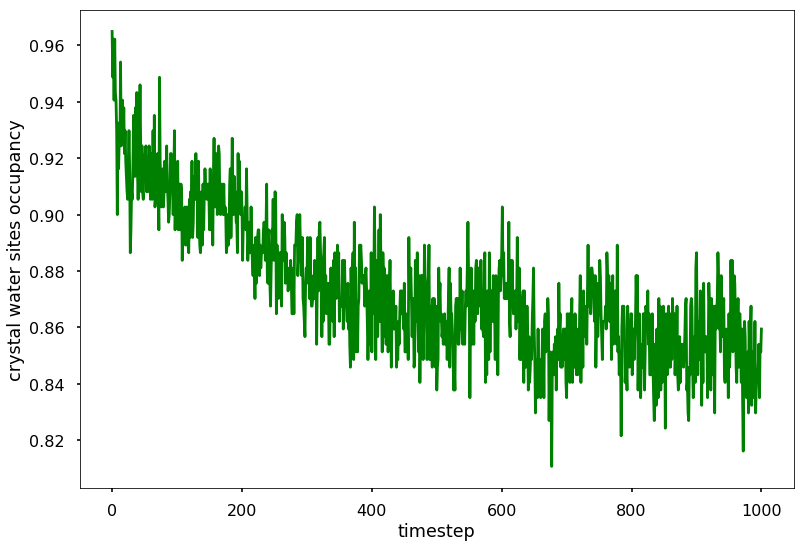

In [442]:
plt.plot(percent, 'g-')
plt.xlabel('timestep')
plt.ylabel('crystal water sites occupancy')

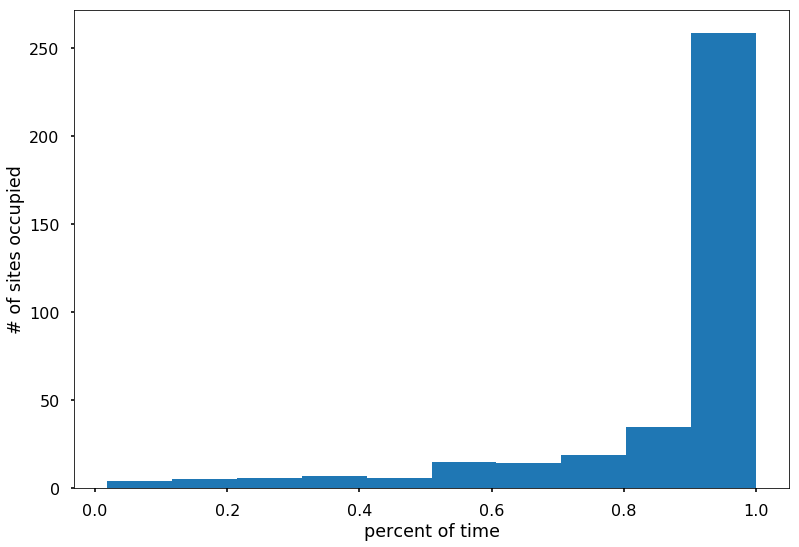

In [425]:
plt.hist(av_percent)
plt.ylabel('# of sites occupied')
plt.xlabel('percent of time')
plt.show()

## SImilar analysis for the random water sites:

In [443]:
sample_oxygens = np.random.choice(oxygens.atoms.indices, size=370)

In [444]:
random_waters_selection = u_berendsen.select_atoms('resname HUI')
for index in sample_oxygens:
    random_waters_selection += u_berendsen.atoms[index] 
print(random_waters_selection.n_atoms) 

370


In [445]:
u_berendsen.trajectory[0]
fixed_random_coords = random_waters_selection.positions.copy()

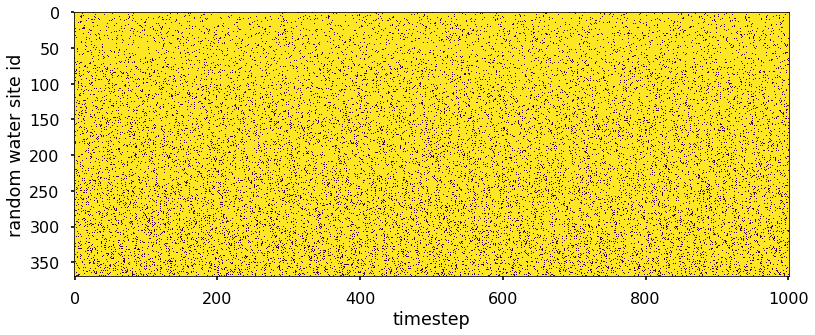

In [446]:
u_berendsen = md.Universe('../Rama-Crystal-1/NPT/simfiles/solvate_genion.gro','../Rama-Crystal-1/NPT/BerendsenRun/traj.xtc')
occupancy = np.zeros((1001, 370))
#result = np.empty((370, 1159))
oxygens = u_berendsen.select_atoms('resname SOL and name OW')
counter = 0
for ts in u_berendsen.trajectory:
    box = ts.dimensions
    d = distance_array(fixed_random_coords.reshape((-1, 3)), oxygens.positions, box=box, result=None, backend='OpenMP')
    mindist = np.min(d, axis=1)
    occupancy[counter] = mindist
    counter += 1
plt.imshow(occupancy.reshape((370,-1)) < cutoff)
plt.xlabel('timestep')
plt.ylabel('random water site id')
plt.show()

In [447]:
av_percent2 = np.sum(occupancy < cutoff, axis = 0) / 1001.
percent2 = np.sum(occupancy < cutoff, axis = 1) / 370.

Text(0, 0.5, 'crystal water sites occupancy')

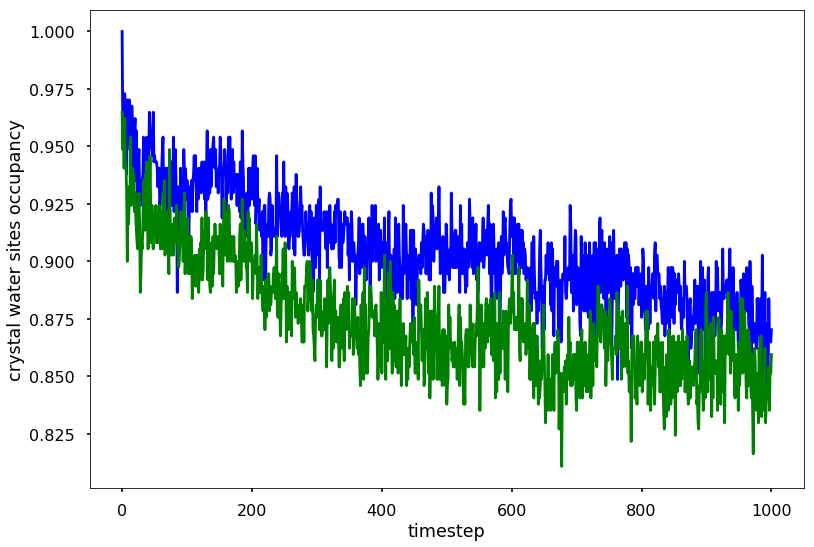

In [448]:
plt.plot(percent2, 'b-', percent ,'g-')
plt.xlabel('timestep')
plt.ylabel('crystal water sites occupancy')

In [309]:
u_berendsen.select_atoms('not protein')

<AtomGroup with 3489 atoms>

## Approach number 2. 
### Here I do alignment of the structures and modify water coordinates so that there is no inconsistency

In [8]:
crystal_waters = u1.select_atoms('resname HOH and name OW')
crystal_coords = crystal_waters.positions.copy()

### check the size of the array:

In [9]:
crystal_coords.shape

(376, 3)

In [32]:
u_berendsen = md.Universe('../Rama-Crystal-1/NPT/BerendsenRun/Berendsen.gro','../Rama-Crystal-1/NPT/BerendsenRun/traj_whole_nojump_center_compact.xtc.xtc')

In [33]:
protein_u1 = u1.select_atoms('protein')

In [34]:
protein_berendsen = u_berendsen.select_atoms('protein')

In [35]:
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis.distances import distance_array

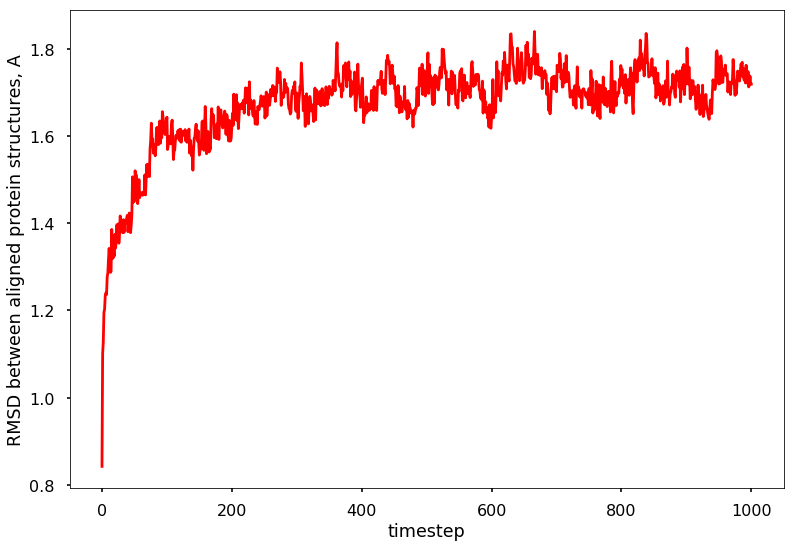

In [36]:
rmsds = []
for ts in u_berendsen.trajectory:
    rmsds.append(rmsd(protein_u1.positions, protein_berendsen.positions, superposition=True))
plt.plot(rmsds, 'r-')
plt.xlabel('timestep')
plt.ylabel('RMSD between aligned protein structures, A')
plt.show()

In [ ]:
"""
mobile0 = mobile.select_atoms('name CA').positions - mobile.atoms.center_of_mass()
ref0 = ref.select_atoms('name CA').positions - ref.atoms.center_of_mass()
R, rmsd = align.rotation_matrix(mobile0, ref0)
mobile.atoms.translate(-mobile.select_atoms('name CA').center_of_mass())
mobile.atoms.rotate(R)
mobile.atoms.translate(ref.select_atoms('name CA').center_of_mass())
mobile.atoms.write("mobile_on_ref.pdb")
"""

376


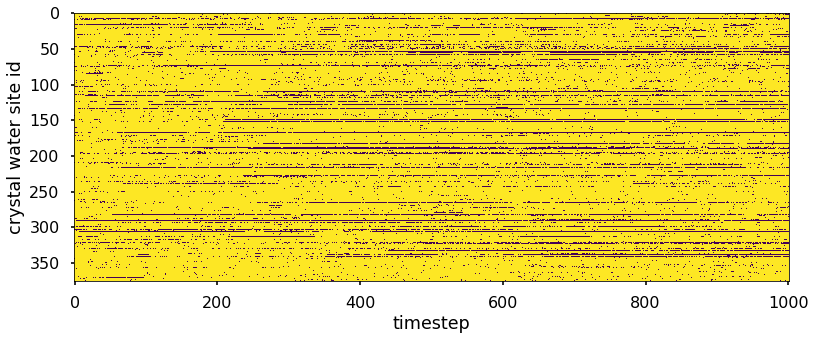

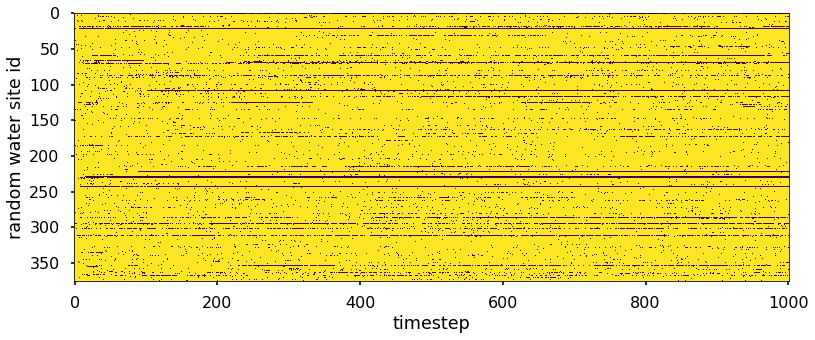

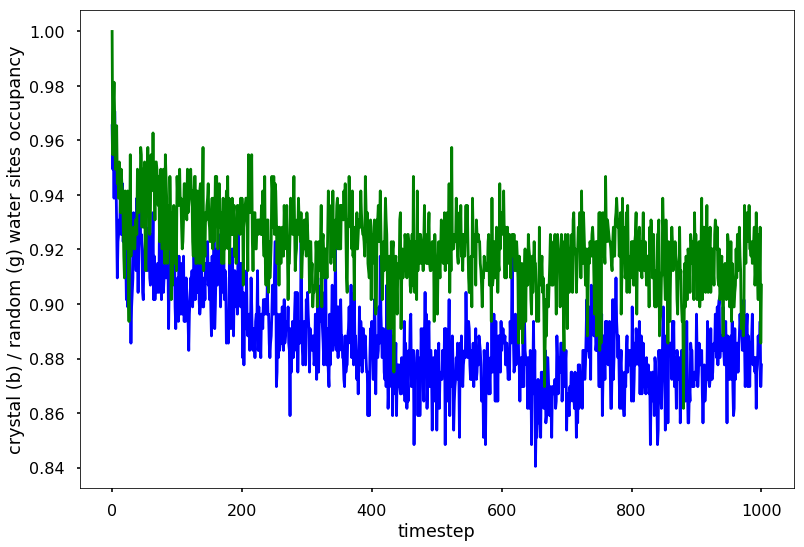

In [70]:
u0 = md.Universe('../Rama-Crystal-1/NPT/simfiles/init.gro')
u_berendsen = md.Universe('../Rama-Crystal-1/NPT/BerendsenRun/Berendsen.gro','../Rama-Crystal-1/NPT/BerendsenRun/traj_whole_nojump_center_compact.xtc')

protein_u0 = u0.select_atoms('protein')
protein_berendsen = u_berendsen.select_atoms('protein')

oxygens = u_berendsen.select_atoms('resname SOL and name OW')
crystal_waters0 = u0.select_atoms('resname HOH and name OW')


u1 = md.Universe('../Rama-Crystal-1/NPT/simfiles/init.gro')
protein_u1 = u1.select_atoms('protein')
crystal_waters = u1.select_atoms('resname HOH and name OW')

cutoff = 2.5

occupancy = np.zeros((1001, 376))


sample_oxygens = np.random.choice(oxygens.atoms.indices, size=376, replace=False)
random_waters_selection = u_berendsen.select_atoms('resname HUI')
for index in sample_oxygens:
    random_waters_selection += u_berendsen.atoms[index] 
print(random_waters_selection.n_atoms)
u_berendsen.trajectory[0]
fixed_random_coords = random_waters_selection.positions.copy()

random_occupancy = np.zeros((1001, 376))

counter = 0
for ts in u_berendsen.trajectory:
    
    mobile0 = protein_u0.positions - protein_u0.atoms.center_of_mass()
    ref0 = protein_berendsen.positions - protein_berendsen.atoms.center_of_mass()
    R, rmsd = align.rotation_matrix(mobile0, ref0)
    crystal_waters.positions = crystal_waters0.positions
    crystal_waters.atoms.translate(-protein_u0.atoms.center_of_mass())
    crystal_waters.atoms.rotate(R)
    crystal_waters.atoms.translate(protein_berendsen.atoms.center_of_mass())
    
    box = ts.dimensions
    d = distance_array(crystal_waters.positions, oxygens.positions, box=box, result=None, backend='OpenMP')
    mindist = np.min(d, axis=1)
    occupancy[counter] = mindist
    #print(d.shape, mindist.shape)
    random_d = distance_array(fixed_random_coords.reshape((-1, 3)), oxygens.positions, box=box, result=None, backend='OpenMP')
    random_mindist = np.min(random_d, axis=1)
    random_occupancy[counter] = random_mindist
    #print(random_d.shape, random_mindist.shape)
    
    counter += 1 
    
plt.imshow(occupancy.T < cutoff)
plt.xlabel('timestep')
plt.ylabel('crystal water site id')
plt.show()

plt.imshow(random_occupancy.T < cutoff)
plt.xlabel('timestep')
plt.ylabel('random water site id')
plt.show()

percent = np.sum(occupancy < cutoff, axis = 1) / 376.
random_percent = np.sum(random_occupancy < cutoff, axis = 1) / 376.
plt.plot(percent, 'b-', random_percent, 'g-')
plt.xlabel('timestep')
plt.ylabel('crystal (b) / random (g) water sites occupancy')
plt.show()